In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

from sklearn.feature_extraction import image

%matplotlib inline

In [2]:
dropout = np.load('test_preds/dropout/dropout.npz')
swag = np.load('test_preds/swag_cov/swag_50.npz')
swag_diag = np.load('test_preds/swag/swag.npz')
swa = np.load('swa_preds.npz')
sgd = np.load('sgd_preds.npz')

In [3]:
def softmax(x, axis=1):
    return np.exp(x) / np.sum(np.exp(x),axis=axis, keepdims=True)

In [4]:
def compute_local_accuracy(predictions, labels, patch_size = 4):
    
    acc_list = []
    for i, (pred, label)in enumerate(zip(predictions, labels)):
        if i % 10 is 0:
            print(i)
        pred_patches = image.extract_patches_2d(pred, (patch_size, patch_size))
        label_patches = image.extract_patches_2d(label, (patch_size, patch_size))
        
        mean_accuracy = (pred_patches == label_patches).mean(axis=(1,2))
                
        acc_list.append(mean_accuracy)
    return acc_list
        

In [5]:
def compute_local_confidence(max_predictions, patch_size = 4):
    conf_list = []
    for pred in max_predictions:
        pred_patches = image.extract_patches_2d(pred, (patch_size, patch_size))
        mean_conf = pred_patches.mean(axis=(1,2))
        conf_list.append(mean_conf)
    return conf_list

In [6]:
drop_acc = np.array(compute_local_accuracy(np.argmax(dropout['predictions'],1), dropout['targets']))
drop_conf = np.array(compute_local_confidence(np.max(dropout['predictions'],1)))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


In [7]:
swag_acc = np.array(compute_local_accuracy(np.argmax(swag['predictions'],1), swag['targets']))
swag_conf = np.array(compute_local_confidence(np.max(swag['predictions'],1)))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


In [8]:
swag_diag_acc = np.array(compute_local_accuracy(np.argmax(swag_diag['predictions'],1), swag_diag['targets']))
swag_diag_conf = np.array(compute_local_confidence(np.max(swag_diag['predictions'],1)))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


In [9]:
swa_acc = np.array(compute_local_accuracy(np.argmax(swa['preds'],1), swa['targets']))
swa_conf = np.array(compute_local_confidence(np.max(softmax(swa['preds'],1),1)))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


In [10]:
sgd_acc = np.array(compute_local_accuracy(np.argmax(sgd['preds'],1), sgd['targets']))
sgd_conf = np.array(compute_local_confidence(np.max(softmax(sgd['preds'],1),1)))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


In [11]:
unc_thresholds = np.arange(0., 1., 0.05)

def conditional_acc_unc(acc, conf, thresholds = unc_thresholds, acc_threshold = 0.5):
    mean_acc = np.zeros_like(thresholds)
    mean_unc = np.zeros_like(thresholds)
    pa_vpu = np.zeros_like(thresholds)
    for i, u in enumerate(thresholds):
        ac = ((conf > u) & (acc > acc_threshold)).sum()
        ic = ((conf > u) & (acc < acc_threshold)).sum()
        
        iu = ((conf < u) & (acc < acc_threshold)).sum()
        au = ((conf < u) & (acc > acc_threshold)).sum()
        mean_acc[i] = ac / (ac + ic)
        mean_unc[i] = iu / (ic + iu)
        pa_vpu[i] = (ac + iu) / (ac + au + ic + iu)
        
        
    return mean_acc, mean_unc, pa_vpu

In [11]:
((drop_acc > 0.2) & (drop_conf < 0.5)).sum()

695213

In [12]:
drop_mean_acc, drop_mean_unc, drop_pa = conditional_acc_unc(drop_acc, drop_conf)
swa_mean_acc, swa_mean_unc, swa_pa = conditional_acc_unc(swa_acc, swa_conf)
sgd_mean_acc, sgd_mean_unc, sgd_pa = conditional_acc_unc(sgd_acc, sgd_conf)
swag_diag_mean_acc, swag_diag_mean_unc, swag_diag_pa = conditional_acc_unc(swag_diag_acc, swag_diag_conf)
swag_mean_acc, swag_mean_unc, swag_pa = conditional_acc_unc(swag_acc, swag_conf)

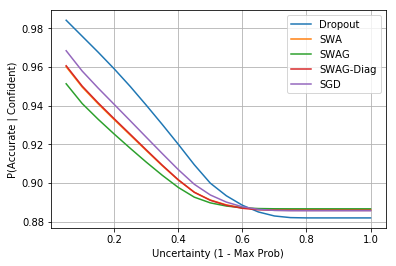

In [21]:
plt.plot(1-unc_thresholds, drop_mean_acc, label = 'Dropout')
plt.plot(1-unc_thresholds, swa_mean_acc, label = 'SWA')
plt.plot(1-unc_thresholds, swag_mean_acc, label = 'SWAG')
plt.plot(1-unc_thresholds, swag_diag_mean_acc, label = 'SWAG-Diag')
plt.plot(1-unc_thresholds, sgd_mean_acc, label = 'SGD')
plt.xlabel('Uncertainty (1 - Max Prob)')
plt.ylabel('P(Accurate | Confident)')
plt.grid()
plt.legend()
plt.savefig('/home/wesley/Documents/Papers/udl_paper_source/icml/plots/segmentation_acc_conf.eps')

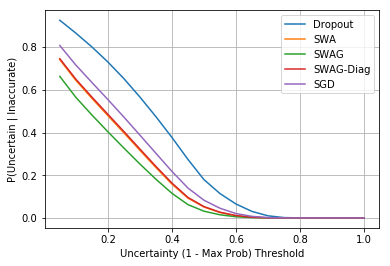

In [22]:
plt.plot(1 - unc_thresholds, drop_mean_unc, label = 'Dropout')
plt.plot(1-unc_thresholds, swa_mean_unc, label = 'SWA')
plt.plot(1-unc_thresholds, swag_mean_unc, label = 'SWAG')
plt.plot(1-unc_thresholds, swag_diag_mean_unc, label = 'SWAG-Diag')
plt.plot(1-unc_thresholds, sgd_mean_unc, label='SGD')
plt.ylabel('P(Uncertain | Inaccurate)')
plt.xlabel('Uncertainty (1 - Max Prob) Threshold')
plt.grid()
plt.legend()
plt.savefig('/home/wesley/Documents/Papers/udl_paper_source/icml/plots/segmentation_unc_inacc.eps')

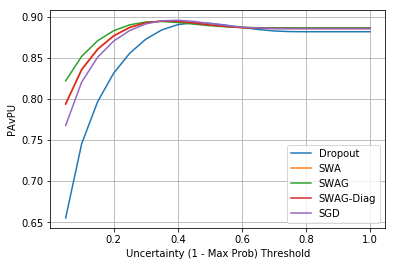

In [23]:
plt.plot(1 - unc_thresholds, drop_pa, label = 'Dropout')
plt.plot(1-unc_thresholds, swa_pa, label = 'SWA')
plt.plot(1-unc_thresholds, swag_pa, label='SWAG')
plt.plot(1-unc_thresholds, swag_diag_pa, label = 'SWAG-Diag')
plt.plot(1-unc_thresholds, sgd_pa, label='SGD')
plt.ylabel('PAvPU')
plt.xlabel('Uncertainty (1 - Max Prob) Threshold')
plt.grid()
plt.legend()
plt.savefig('/home/wesley/Documents/Papers/udl_paper_source/icml/plots/segmentation_pavpu.eps')

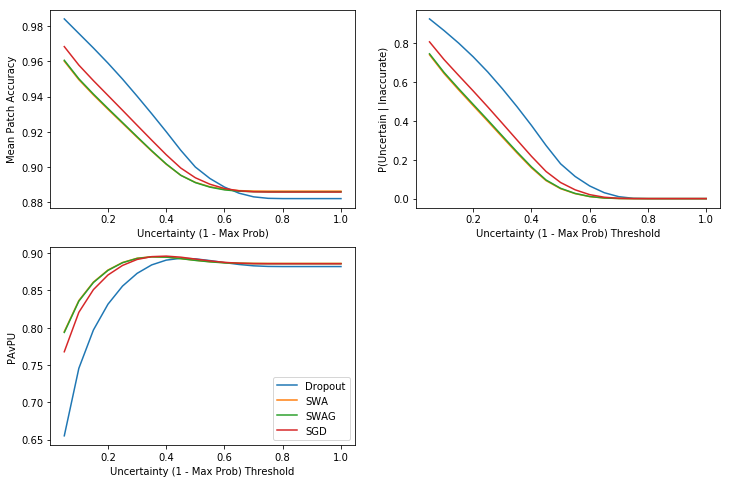

In [23]:
plt.rcParams["figure.figsize"] = (12,8)
plt.subplot(221)
plt.plot(1-unc_thresholds, drop_mean_acc, label = 'Dropout')
plt.plot(1-unc_thresholds, swa_mean_acc, label = 'SWA')
plt.plot(1-unc_thresholds, swag_mean_acc, label = 'SWAG')
plt.plot(1-unc_thresholds, sgd_mean_acc, label = 'SGD')
plt.xlabel('Uncertainty (1 - Max Prob)')
plt.ylabel('Mean Patch Accuracy')

plt.subplot(222)
plt.plot(1 - unc_thresholds, drop_mean_unc, label = 'Dropout')
plt.plot(1-unc_thresholds, swa_mean_unc, label = 'SWA')
plt.plot(1-unc_thresholds, swag_mean_unc, label = 'SWAG')
plt.plot(1-unc_thresholds, sgd_mean_unc, label='SGD')
plt.ylabel('P(Uncertain | Inaccurate)')
plt.xlabel('Uncertainty (1 - Max Prob) Threshold')

plt.subplot(223)
plt.plot(1 - unc_thresholds, drop_pa, label = 'Dropout')
plt.plot(1-unc_thresholds, swa_pa, label = 'SWA')
plt.plot(1-unc_thresholds, swag_pa, label='SWAG')
plt.plot(1-unc_thresholds, sgd_pa, label='SGD')
plt.ylabel('PAvPU')
plt.xlabel('Uncertainty (1 - Max Prob) Threshold')
plt.legend()
